In [5]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import julian
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

In [7]:
#Root directory: change to where data downloaded to
root_dir = '/data2/jbaldwin/WCAS2023'

In [6]:
ts_per_year = pickle.load(open(root_dir+"/HAZARD/WIND_SWATHS/IBTrACS/ts_per_year_maxasymcorrec.p","rb"))
regions = list(ts_per_year.keys())

# Calculate number of storms for different provinces
ts_per_year_map = xr.Dataset.copy(d_mask)
for key in regions:
    ts_per_year_map.states.values[ts_per_year_map.states==state_ids[key]] = ts_per_year[key]

ts_per_year_map.to_netcdf(root_dir+'/HAZARD/WIND_SWATHS/IBTrACS/ts_per_year_maxasymcorrec.nc')

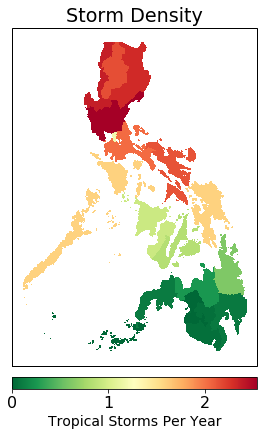

In [8]:
# Make plot of tropical storms per year

ts_per_year_map = xr.open_dataset(root_dir+'/HAZARD/WIND_SWATHS/IBTrACS/ts_per_year_maxasymcorrec.nc')

plt.figure(figsize=(4, 8))
plt.rcParams.update({'font.size': 16})
plt.subplot(111,projection=ccrs.PlateCarree())
p = ts_per_year_map.states.plot(transform=ccrs.PlateCarree(),cmap = plt.cm.RdYlGn_r, add_colorbar = False)
plt.title('Storm Density')
cb = plt.colorbar(p, orientation="horizontal",pad=0.02)
cb.set_label(label='Tropical Storms Per Year',fontsize=14)
plt.savefig(root_dir+'/FIGURES/ts_per_year_maxasymcorrec.png',dpi=600)
plt.tight_layout()

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


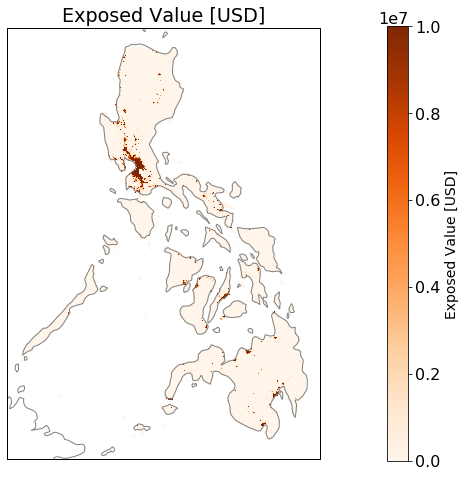

In [11]:
# Exposed Value Data, subset over Philippines
ds_exp = xr.open_dataset(root_dir+'/EXPOSED_VALUE/litpop_v1-2_phl.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
exposed_value = ds_exp.value

# Make plot of Exposed Value
plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 16})
ax = plt.subplot(111,projection=ccrs.PlateCarree())
p = exposed_value.plot(transform=ccrs.PlateCarree(),cmap = plt.cm.Oranges, add_colorbar = False, vmax = 1e7)
p.axes.coastlines('50m',color='0.5')
plt.title('Exposed Value [USD]')
cb = plt.colorbar(p, orientation="vertical", pad=0.15)
cb.set_label(label='Exposed Value [USD]',fontsize=14)
#ax.add_feature(cfeature.OCEAN, zorder=100)
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
plt.savefig(root_dir+'/FIGURES/exposed_value_map.png',dpi=400)


/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


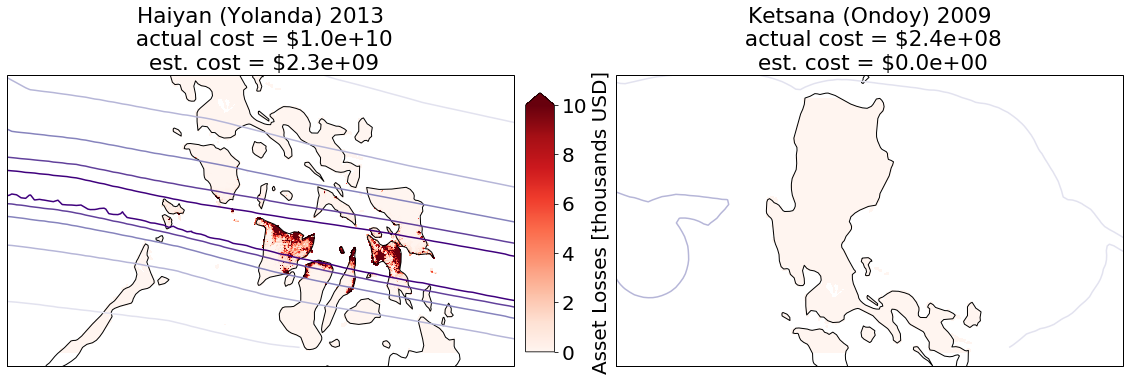

In [8]:
# EMDAT
loss_haiyan = 10000000000
loss_ondoy = 237489000

# Load the swath data
ds_swaths = xr.open_dataset(root_dir+'/HAZARD/WIND_SWATHS/IBTrACS/wspd_phi_swaths_maxasymcorrec_ibtracsv04r00_3-8-21.nc')
swath = ds_swaths.swath

# Load the asset losses data
dat = xr.open_dataset(root_dir+'/ASSET_LOSSES/IBTrACS/regionvulnerability_rmsf_2.nc')
asset_losses = dat.asset_losses
est_cost = asset_losses.sum(dim='lon').sum(dim='lat')

fig = plt.figure(figsize=(20, 9))
p = {}
plt.rcParams.update({'font.size': 18})

vmax = 10

plt.subplot(1,2,1,projection=ccrs.PlateCarree())
n = 434
latmin = 9
latmax = 15
p[n] = (asset_losses[...,n]/1000).sel(lat = slice(latmin,latmax)).plot(vmax = vmax,transform=ccrs.PlateCarree(),cmap=plt.cm.Reds,extend = 'max', add_colorbar=False)
data = swath[n].sel(lat = slice(latmin,latmax))
data.plot.contour(transform=ccrs.PlateCarree(),cmap = plt.cm.Purples,levels=np.arange(0,60,10),add_colorbar=False,linewidth=0.5)
p[n].axes.coastlines('50m')
plt.title('Haiyan (Yolanda) 2013'+'\n actual cost = $'+"{:.1e}".format(int(loss_haiyan),decimals=1)+'\n est. cost = $'+"{:.1e}".format(int(est_cost[n])))

plt.subplot(1,2,2,projection=ccrs.PlateCarree())
n = 407
latmin = 13
latmax = 19
p[n] = (asset_losses[...,n]/1000).sel(lat = slice(latmin,latmax)).plot(vmax = vmax,transform=ccrs.PlateCarree(),cmap=plt.cm.Reds, extend = 'max', add_colorbar = False)
data = swath[n].sel(lat = slice(latmin,latmax))
data.plot.contour(transform=ccrs.PlateCarree(),cmap = plt.cm.Purples,levels=np.arange(0,60,10),add_colorbar=False,linewidth=0.5)
p[n].axes.coastlines('50m')
plt.title('Ketsana (Ondoy) 2009'+'\n actual cost = $'+"{:.1e}".format(int(loss_ondoy),decimals=1)+'\n est. cost = $'+"{:.1e}".format(int(est_cost[n])))

#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.485, 0.3, 0.02, 0.4])
cb = fig.colorbar(p[407], cax=cbar_ax, extend = 'max')
cb.set_label(label='Asset Losses [thousands USD]',size=20)
cb.ax.tick_params(labelsize=20) 
plt.savefig(root_dir+'/FIGURES/haiyanvketsana.png',dpi=600)
